# Accessing PA Offshore Profiler Mooring (CP04OSPM) Telemetered CTD Data via R

### The Example Parameters
In this example we will be requesting telemetered CTD data from the Pioneer Array Offshore Profiler Mooring (CP04OSPM) for the months of February - April 2021. After requesting and downloading the data, we will make a false colored scatter plot of temperature with respect to time and depth.

__Site__: [CP04OSPM](https://oceanobservatories.org/site/cp04ospm/)

__Node__: WFP01

__Instrument__: [03-CTDPFK000](https://ooinet.oceanobservatories.org/data_access/?search=CP04OSPM-WFP01-03-CTDPFK000)

__Method__: telemetered

__Stream__: ctdpf_ckl_wfp_instrument

__Start Date__: 2021-02-01

__Start Time__: 00:00:00

__Stop Date__: 2021-04-30

__Stop Time__: 23:59:59

### Installing Required Packages
The OOI has developed a curated R package for accessing OOI science data via the machine-to-machine interface. This package is called [OOIM2MR](https://github.com/oceanobservatories/ooim2mr) and is intended to be a one stop shop for requesting and downloading science data from any stationary or mobile OOI asset.

In order to install OOIM2MR, you will first need to install the devtools package. Devtools allows you to install correctly formatted GitHub repositories as callable packages within your R environment.

In [1]:
install.packages("devtools")

package 'devtools' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Ian\AppData\Local\Temp\Rtmp8ahmnT\downloaded_packages


Once you've successfully installed devtools, you can install OOIM2MR using the install_github command. You may receive a Rtools warning. This can be ignored.

In [2]:
devtools::install_github("oceanobservatories/ooim2mr")


Please download and install Rtools 4.0 from https://cran.r-project.org/bin/windows/Rtools/, remove the incompatible version from your PATH.

Skipping install of 'ooim2mr' from a github remote, the SHA1 (2287a1d5) has not changed since last install.
  Use `force = TRUE` to force installation



You will also need to install the httr and ncdf4 packages. In this example we will also be creating a plot, but there are many packages that allow you to do this. We'll use ggplot2 for plotting and RColorBrewer for coloring. The OOIM2MR package also requires the R native stringr and jsonlite packages.

In [3]:
install.packages("httr")
install.packages("ncdf4")
install.packages("ggplot2")

package 'httr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Ian\AppData\Local\Temp\Rtmp8ahmnT\downloaded_packages
package 'ncdf4' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Ian\AppData\Local\Temp\Rtmp8ahmnT\downloaded_packages
package 'ggplot2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Ian\AppData\Local\Temp\Rtmp8ahmnT\downloaded_packages


# Setup
After successful installation of the required packages, we can begin to import said packages and define our request parameters.

In [4]:
#R Native Packages
library(stringr)
library(jsonlite)

#CRAN Packages
library(httr)
library(ncdf4)
library(ooim2mr)
library(ggplot2)
library(RColorBrewer)

Warning message:
"package 'httr' was built under R version 4.0.5"
Warning message:
"package 'ggplot2' was built under R version 4.0.5"


If you're using Windows, the ncdf4 package has a bug that prevents Windows users from accessing remote NetCDF files. The work around for this is to specify a directory where you can download the files and then access them locally. Keep in mind that some of these files can be large and may take time to both download and open. In addition to specifying a directory, you'll need to supply your OOI username and token for issuing requests to OOINet. If you are running this code as a full script, you'll need to change the next cell to match your system and credentials.

In [5]:
directory = "C:/Users/Ian/Desktop"  #Change this to match you own machine structure.
user = 'OOIAPI-J4N6210YT5FEWL'  #Change this to match your OOINet username.
token = 'BED44SNR82A'  #Change this to match your OOINet token.

Next we can set up our request parameters.

In [6]:
site = "CP04OSPM" 
node = "WFP01" 
instrument = "03-CTDPFK000" 
method = "telemetered" 
stream = "ctdpf_ckl_wfp_instrument" 
start_date = "2021-02-01" 
start_time = "00:00:00" 
stop_date = "2021-04-3"
stop_time = "23:59:59"

## Requesting, Downloading, and Importing Data
Now that we have our directory, credentials, and request parameters, we can build a URL for issuing a request to OOI. The [ooi_create_url](https://github.com/oceanobservatories/ooim2mr/blob/master/R/ooi_create_url.R) function from the OOIM2MR package uses a curated table for finding the correct URL, taking the guess work out of creating a URL with the correct syntax.

In [7]:
url = ooi_create_url(site=site,
                     node=node,
                     instrument=instrument,
                     method=method,
                     stream=stream,
                     start_date=start_date,
                     start_time=start_time,
                     stop_date=stop_date,
                     stop_time=stop_time)

Here is the request URL generated from the information you provided.
https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CP04OSPM/WFP01/03-CTDPFK000/telemetered/ctdpf_ckl_wfp_instrument?beginDT=2021-02-01T00:00:00.000Z&endDT=2021-04-3T23:59:59.999Z 


Now that we have the correct URL, we can submit our data request to OOINet using the [ooi_submit_request](https://github.com/oceanobservatories/ooim2mr/blob/master/R/ooi_submit_request.R) function.

In [8]:
response = ooi_submit_request(url=url,user=user,token=token)

Request issued at 2021-04-23 19:15:52.
Request successful (200).


Requests can take anywhere between 1-30 minutes depending on the data you requested. After a request is submitted, the [ooi_get_location](https://github.com/oceanobservatories/ooim2mr/blob/master/R/ooi_get_location.R) function continuously checks the status of your data request. Once it is complete, the function returns the remote locations of your data as a list of Thredds catalog URLs. Some dataset requests have paired data, which can cause problems when trying to import data from multiple files. For example, when requesting fluorometer data, you'll also get CTD data. Setting the drop_paired parameter to TRUE allows you to scrub those extra files and get the data that you requested.

In [9]:
remote = ooi_get_location(response=response,drop_paired=TRUE)

Checking data status...
Request took ~95 seconds to complete.
For your records, the online catalog of your data request can be found here:  https://opendap.oceanobservatories.org/thredds/catalog/ooi/ian.black@oregonsate.edu/20210423T191547121Z-CP04OSPM-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument/catalog.html 
Data are now available to download at these remote location(s).
[1] "https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ian.black@oregonsate.edu/20210423T191547121Z-CP04OSPM-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument/deployment0013_CP04OSPM-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument_20210201T030041.200000-20210403T214410.nc"


Once the data is available, we can download it using the [ooi_download_data](https://github.com/oceanobservatories/ooim2mr/blob/master/R/ooi_download_data.R) function. As stated previously, if you are using a Windows machine you need to supply a directory where you want to download the data. If you are MacOS and don't want to download the data, you can skip the use of this function and directly input the URLs found in the remote variable into the ooi_get_data function.

In [10]:
local = ooi_download_data(remote,directory) #Download the data to the specified local location.

Files have been downloaded and named as follows.
[1] "C:/Users/Ian/Desktop/CP04OSPM_WFP01_CTDPFK000_telemetered_deployment0013_20210201T030041.200000-20210403T214410.nc"


Once the data is downloaded, we can pull it into our workspace. If you have experience with NetCDFs, you can do this on your own. The OOIM2MR package also provides the [ooi_get_data](https://github.com/oceanobservatories/ooim2mr/blob/master/R/ooi_get_data.R) function which simplifies the data import process. If using the ooi_get_data function, the simplify_data parameter will remove non L1 or L2 variable types and engineering variables that can be confusing if it is set to TRUE. In this example, we set it to FALSE, which brings in all of the data in the files. If the data you are working with is multidimensional, you will need to set the simplify_data parameter to FALSE, because its functionality assumes that the data is 1D. The return of the ooi_get_data function is two lists. The first list contains the data and the second list contains a list of variables and associated units. Once data is imported, we can put each list into its own data.frame for easier access.

In [11]:
data_vars = ooi_get_data(local,simplify_data=FALSE)
data = data.frame(data_vars[['data']])
vars = data.frame(data_vars[['variables_units']])

Data from file (1) has been read in.
Data are now in the workspace.


If we print the vars list, we can see the variables that are available in the data we requested as well as units associated with those variables. Since we are going to plot temperature in this example, it is easy to make the mistake that we would use the "temperature" variable, but if you look at the units it is in counts. The variable that we actually want to use is "ctdpf_ckl_seawater_temperature".

In [12]:
print(vars)

                                         variables
1                               practical_salinity
2       ctdpf_ckl_seawater_conductivity_qc_results
3   ctdpf_ckl_seawater_temperature_qartod_executed
4          ctdpf_ckl_seawater_pressure_qc_executed
5        ctdpf_ckl_seawater_temperature_qc_results
6                              density_qc_executed
7                                 driver_timestamp
8                                               id
9                                     conductivity
10                   practical_salinity_qc_results
11                                     temperature
12                                         density
13                                      provenance
14                                             lon
15                     ctdpf_ckl_seawater_pressure
16                              internal_timestamp
17  ctdpf_ckl_seawater_conductivity_qartod_results
18     ctdpf_ckl_seawater_conductivity_qc_executed
19   ctdpf_ckl_seawater_tempera

You may notice that the units of "time" are seconds since 1900-01-01. We need to put that into a format that is easier to interpret. The next cell converts the "time" column from seconds since 1900-01-01 to YYYY-MM-DD HH:MM:SS in UTC.

In [13]:
data$time = as.POSIXct(data$time,tz="UTC",origin='1900-01-01')

## Plotting Data
At this point, our data is in our workspace as a data.frame and in a format that we can interpret. Next we need to setup a color palette and color gradient so that our figures look interesting. Additionally, we need to set up the lower and upper limits for our colorbar.

In [14]:
temp_min_lim = 6
temp_max_lim = 18

myPalette <- colorRampPalette(rev(brewer.pal(11, "Spectral")))
sc <- scale_colour_gradientn(colours = myPalette(100), limits=c(temp_min_lim,temp_max_lim))

Next, we can build our figure.

In [15]:
t_plot = ggplot(data,aes(time,depth,colour=ctdpf_ckl_seawater_temperature)) +
  geom_point() + scale_y_reverse() + sc + 
  labs(x='Time',y='Depth (m)',colour = 'Temperature (degC)',title = "CP04OSPM Temperature",subtitle='Feb-Apr 2021')

Finally, we can display our figure.

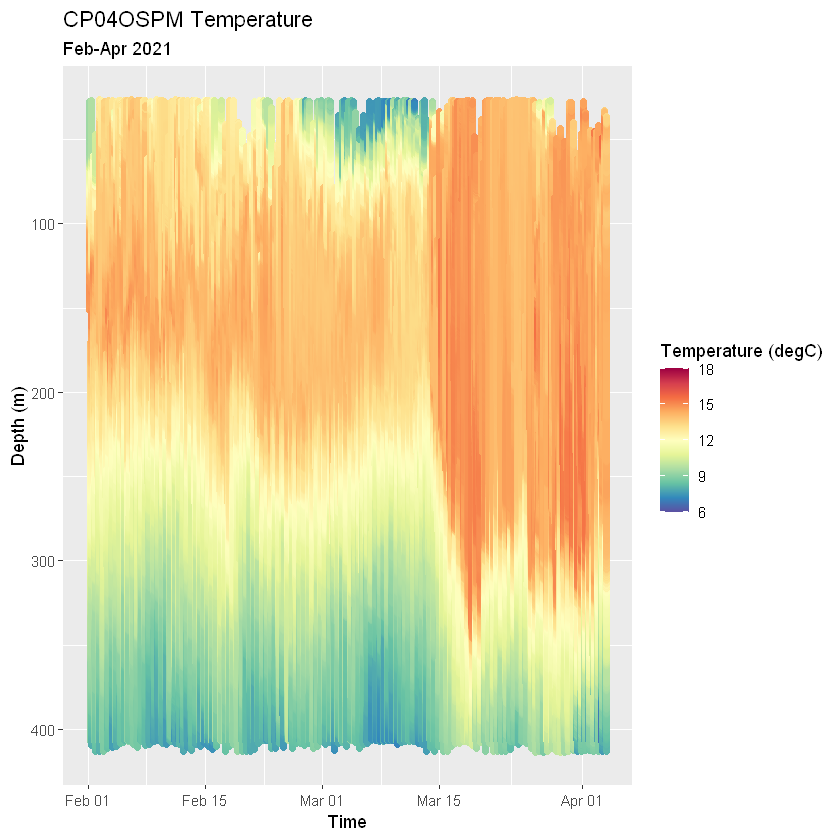

In [16]:
t_plot